In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import xgboost as xgb

### to classification

In [184]:
data=pd.read_csv('transformed_data.csv')

<Axes: xlabel='LogReturn', ylabel='Count'>

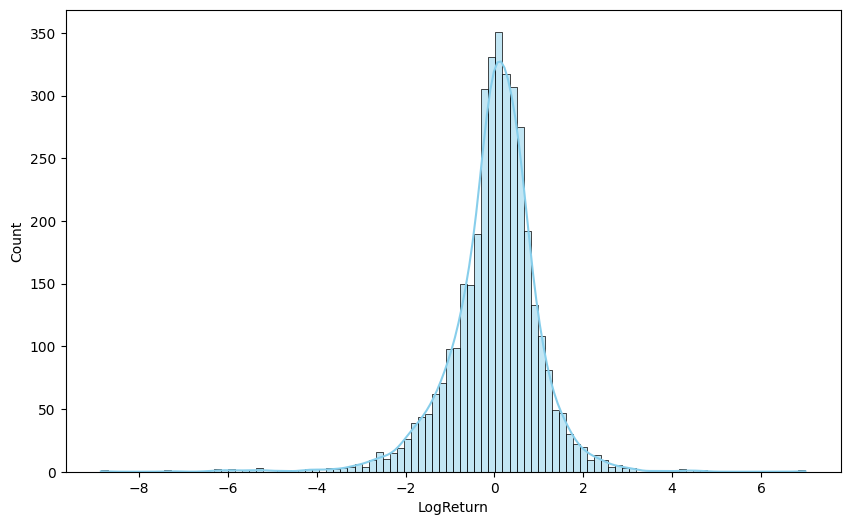

In [185]:
plt.figure(figsize=(10, 6))
sns.histplot(data['LogReturn'], bins=100, kde=True, color='skyblue')

In [186]:
data_class=data.copy()

In [187]:
print(data.shape)         # Ile ma 'data'
print(data_class.shape)   # Ile ma 'data_class'

(3705, 56)
(3705, 56)


### Train test

In [188]:
data_class['date']=pd.to_datetime(data_class['date'])

In [189]:
print(data_class.shape) 

(3705, 56)


In [190]:
data_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3705 entries, 0 to 3704
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   LogReturn                 3705 non-null   float64       
 1   log_volume                3705 non-null   float64       
 2   ma_log_volume             3705 non-null   float64       
 3   prev_day_volume           3705 non-null   float64       
 4   date                      3705 non-null   datetime64[ns]
 5   gdp                       3705 non-null   float64       
 6   interest_rate             3705 non-null   float64       
 7   unemployment              3705 non-null   float64       
 8   cpi                       3705 non-null   float64       
 9   pce                       3705 non-null   float64       
 10  nonfarm_payrolls          3705 non-null   float64       
 11  corporate_profits         3705 non-null   float64       
 12  money_supply        

In [191]:
data_class = data_class.loc[data_class['date'].dt.year < 2019]
data_final_log = data_class.copy()
data_class['LogReturn']=(data['LogReturn'] > 0).astype(int)

In [192]:
X=data_class.drop(['LogReturn','date'],axis=1)
Y=data_class['LogReturn']

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [194]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.32%


In [195]:
X.columns

Index(['log_volume', 'ma_log_volume', 'prev_day_volume', 'gdp',
       'interest_rate', 'unemployment', 'cpi', 'pce', 'nonfarm_payrolls',
       'corporate_profits', 'money_supply', 'consumer_confidence',
       'housing_starts', 'permits', 'interest_rate_lag1', 'unemployment_lag1',
       'cpi_lag1', 'pce_lag1', 'interest_rate_roll3_mean',
       'interest_rate_roll3_std', 'cpi_roll3_mean', 'cpi_roll3_std',
       'interest_x_cpi', 'unemp_x_gdp', 'index', 'Gold_LogReturn', 'Gold_MA10',
       'Gold_MA50', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos',
       'dayofmonth_sin', 'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos',
       'MA10', 'MA50', 'volatility_10', 'MACD', 'MACD_signal', 'BB_upper',
       'BB_lower', 'RSI', 'LogReturn_lag1', 'LogReturn_lag2', 'LogReturn_lag3',
       'LogReturn_lag4', 'LogReturn_lag5', 'LogReturn_lag6', 'LogReturn_lag7',
       'LogReturn_lag8', 'LogReturn_lag9', 'LogReturn_lag10'],
      dtype='object')

/tmp/ipykernel_24198/2633131087.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')


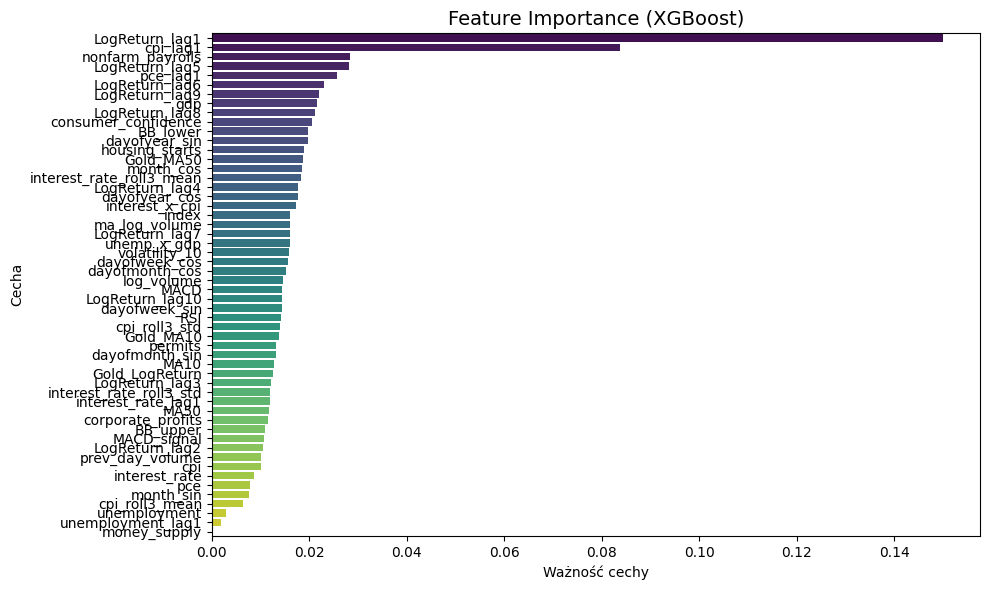

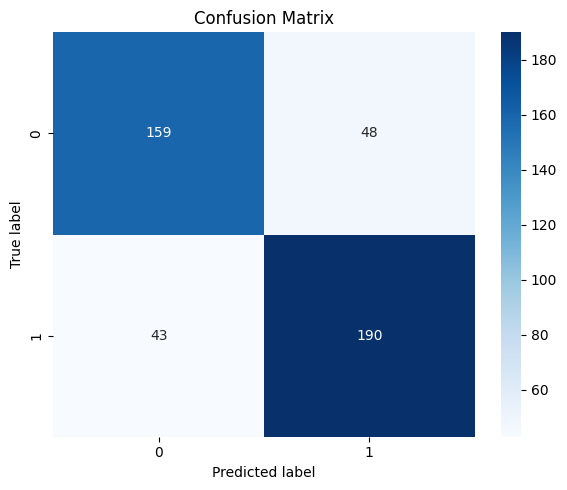

In [196]:
# === FEATURE IMPORTANCE ===
importance = model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Wykres: Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance, palette='viridis')
plt.title('Feature Importance (XGBoost)', fontsize=14)
plt.xlabel('Ważność cechy')
plt.ylabel('Cecha')
plt.tight_layout()
plt.show()

# === CONFUSION MATRIX ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

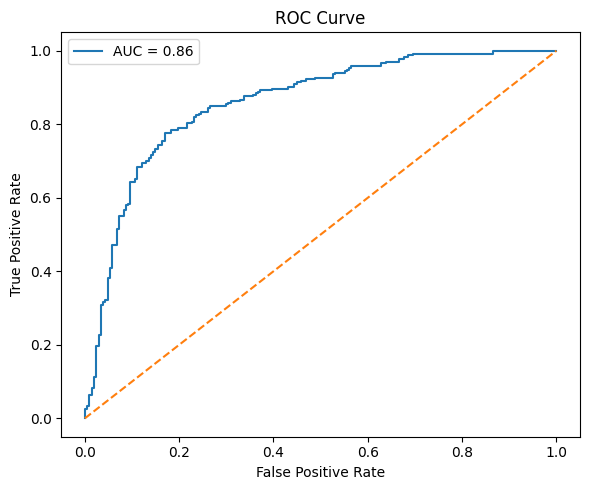

In [197]:
from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

### NEW MODEL

In [198]:
q1 = data['LogReturn'].quantile(0.25)
q2 = data['LogReturn'].quantile(0.50)  # Mediana
q3 = data['LogReturn'].quantile(0.75)

# Tworzymy nowe kolumny klasyfikacji na podstawie kwartyli
def classify_log_return(row):
    if row['LogReturn'] <= q1:
        return 0  # Klasa 0 - pierwszy kwartyl
    elif row['LogReturn'] <= q2:
        return 1  # Klasa 1 - drugi kwartyl
    elif row['LogReturn'] <= q3:
        return 2  # Klasa 2 - trzeci kwartyl
    else:
        return 3  # Klasa 3 - czwarty kwartyl

# Przypisanie klas do danych
data_class4=data.copy()
data_class4['LogReturn'] = data_class4.apply(classify_log_return, axis=1)

# Zobaczmy wyniki
print(data_class4['LogReturn'].head())

0    2
1    2
2    2
3    3
4    3
Name: LogReturn, dtype: int64


In [199]:
data_class4['date']=pd.to_datetime(data_class4['date'])
data_class4 = data_class4.loc[data_class4['date'].dt.year < 2019]
X=data_class4.drop(['LogReturn','date'],axis=1)
Y=data_class4['LogReturn']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Feature importances
importance = model.feature_importances_

# Zamień na tabelkę
feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# Posortuj od najważniejszych
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

print(feat_importance)

Accuracy: 58.18%
                     Feature  Importance
44            LogReturn_lag1    0.120665
5               unemployment    0.037040
18  interest_rate_roll3_mean    0.030683
48            LogReturn_lag5    0.027720
38             volatility_10    0.027686
23               unemp_x_gdp    0.026443
20            cpi_roll3_mean    0.022987
13                   permits    0.021975
42                  BB_lower    0.020143
9          corporate_profits    0.019896
49            LogReturn_lag6    0.019446
16                  cpi_lag1    0.019442
8           nonfarm_payrolls    0.019211
50            LogReturn_lag7    0.019091
33            dayofmonth_cos    0.019061
1              ma_log_volume    0.019025
11       consumer_confidence    0.018501
35             dayofyear_cos    0.018022
39                      MACD    0.017802
12            housing_starts    0.017755
29                 month_cos    0.017000
40               MACD_signal    0.016992
47            LogReturn_lag4    0.016666

/tmp/ipykernel_24198/4185270896.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x="importance", y="feature", palette="viridis")


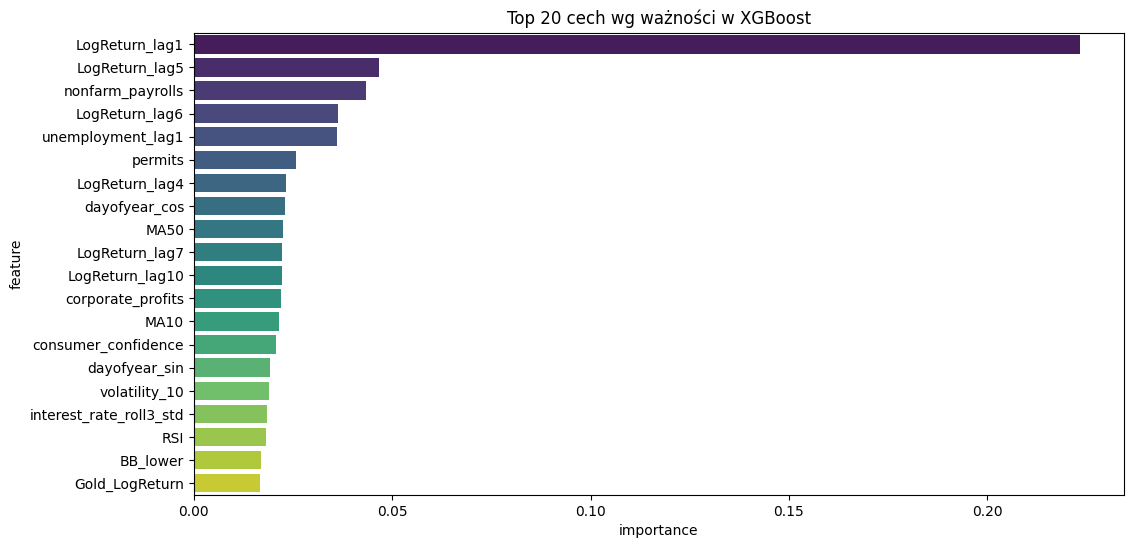

Cechy do usunięcia: ['Gold_MA50', 'dayofmonth_cos', 'MACD_signal', 'BB_upper', 'month_cos', 'LogReturn_lag2', 'LogReturn_lag8', 'housing_starts', 'LogReturn_lag9', 'prev_day_volume', 'month_sin', 'gdp', 'Gold_MA10', 'dayofweek_sin', 'unemp_x_gdp', 'index', 'interest_rate_lag1', 'interest_rate_roll3_mean', 'ma_log_volume', 'log_volume', 'cpi_roll3_std', 'cpi_lag1', 'interest_x_cpi', 'interest_rate', 'cpi', 'unemployment', 'cpi_roll3_mean', 'pce_lag1', 'pce', 'money_supply']


In [200]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#--- Dane wejściowe ---
X = data_class.drop(columns=["date", "LogReturn"])
y = data_class["LogReturn"]

#--- Podział na zbiór treningowy i testowy ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#--- Trening modelu ---
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

#--- Znaczenie cech ---
importances = model.feature_importances_
features = X.columns

#--- Sortowanie i wizualizacja ---
importance_df = pd.DataFrame({"feature": features, "importance": importances})
importance_df = importance_df.sort_values(by="importance", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=importance_df.head(20), x="importance", y="feature", palette="viridis")
plt.title("Top 20 cech wg ważności w XGBoost")
plt.show()
threshold = 0.015
low_importance = importance_df[importance_df["importance"] <= threshold]["feature"].tolist()

print("Cechy do usunięcia:", low_importance)

# Usuwanie ich z danych
X_reduced = X.drop(columns=low_importance)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.2, shuffle=False)

In [201]:
model = xgb.XGBClassifier()
model.fit(X_train_r, y_train_r)
y_pred_r = model.predict(X_test_r)
accuracy = accuracy_score(y_test_r, y_pred_r)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 75.91%


In [202]:
X_reduced.shape
X_reduced.columns

Index(['nonfarm_payrolls', 'corporate_profits', 'consumer_confidence',
       'permits', 'unemployment_lag1', 'interest_rate_roll3_std',
       'Gold_LogReturn', 'dayofweek_cos', 'dayofmonth_sin', 'dayofyear_sin',
       'dayofyear_cos', 'MA10', 'MA50', 'volatility_10', 'MACD', 'BB_lower',
       'RSI', 'LogReturn_lag1', 'LogReturn_lag3', 'LogReturn_lag4',
       'LogReturn_lag5', 'LogReturn_lag6', 'LogReturn_lag7',
       'LogReturn_lag10'],
      dtype='object')

In [203]:
data_class['LogReturn'] = data_final_log["LogReturn"]
data_final = data_class[['LogReturn','nonfarm_payrolls', 'corporate_profits', 'consumer_confidence',
       'permits', 'unemployment_lag1', 'interest_rate_roll3_std',
       'Gold_LogReturn', 'dayofweek_cos', 'dayofmonth_sin', 'dayofyear_sin',
       'dayofyear_cos', 'MA10', 'MA50', 'volatility_10', 'MACD', 'BB_lower',
       'RSI', 'LogReturn_lag1', 'LogReturn_lag3', 'LogReturn_lag4',
       'LogReturn_lag5', 'LogReturn_lag6', 'LogReturn_lag7',
       'LogReturn_lag10']]

In [204]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2200 entries, 0 to 2199
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LogReturn                2200 non-null   float64
 1   nonfarm_payrolls         2200 non-null   float64
 2   corporate_profits        2200 non-null   float64
 3   consumer_confidence      2200 non-null   float64
 4   permits                  2200 non-null   float64
 5   unemployment_lag1        2200 non-null   float64
 6   interest_rate_roll3_std  2200 non-null   float64
 7   Gold_LogReturn           2200 non-null   float64
 8   dayofweek_cos            2200 non-null   float64
 9   dayofmonth_sin           2200 non-null   float64
 10  dayofyear_sin            2200 non-null   float64
 11  dayofyear_cos            2200 non-null   float64
 12  MA10                     2200 non-null   float64
 13  MA50                     2200 non-null   float64
 14  volatility_10            2200

In [205]:
data_final.to_csv("data_final.csv",index=False)